In [1]:
import pandas as pd
import numpy as np

In [2]:
data_path = "../data/raw/abalone.data"
features = ["sex", "length", "diameter", "height", "whole_weight", 
            "shucked_weight", "viscera_weight", "shell_weight", "rings"]
df = pd.read_csv(data_path, sep=",", names=features)


In [3]:
conditions = [
    df["rings"].between(0, 7),
    df["rings"].between(8, 10),
    df["rings"].between(11, 15),
    df["rings"] >15
]

choices = [1, 2, 3, 4]

df["age_class"] = np.select(conditions, choices)
df = df.drop("rings", axis=1)

In [4]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded = encoder.fit_transform(df[["sex"]])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(["sex"]))
df = pd.concat([df.drop("sex", axis=1), encoded_df], axis=1)

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop("age_class", axis=1)
y = df["age_class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=42, stratify=y
)

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

param_distributions = {
    "max_depth": np.arange(1, 11),
    "min_samples_leaf": np.arange(1, 21),
    "min_samples_split": np.arange(2, 51),
    "max_leaf_nodes": np.arange(10, 1001),
    "min_impurity_decrease": np.linspace(0.0, 0.5, 51),
    "criterion": ["gini", "entropy"]
}

search = RandomizedSearchCV(
    estimator = clf,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_clf = search.best_estimator_

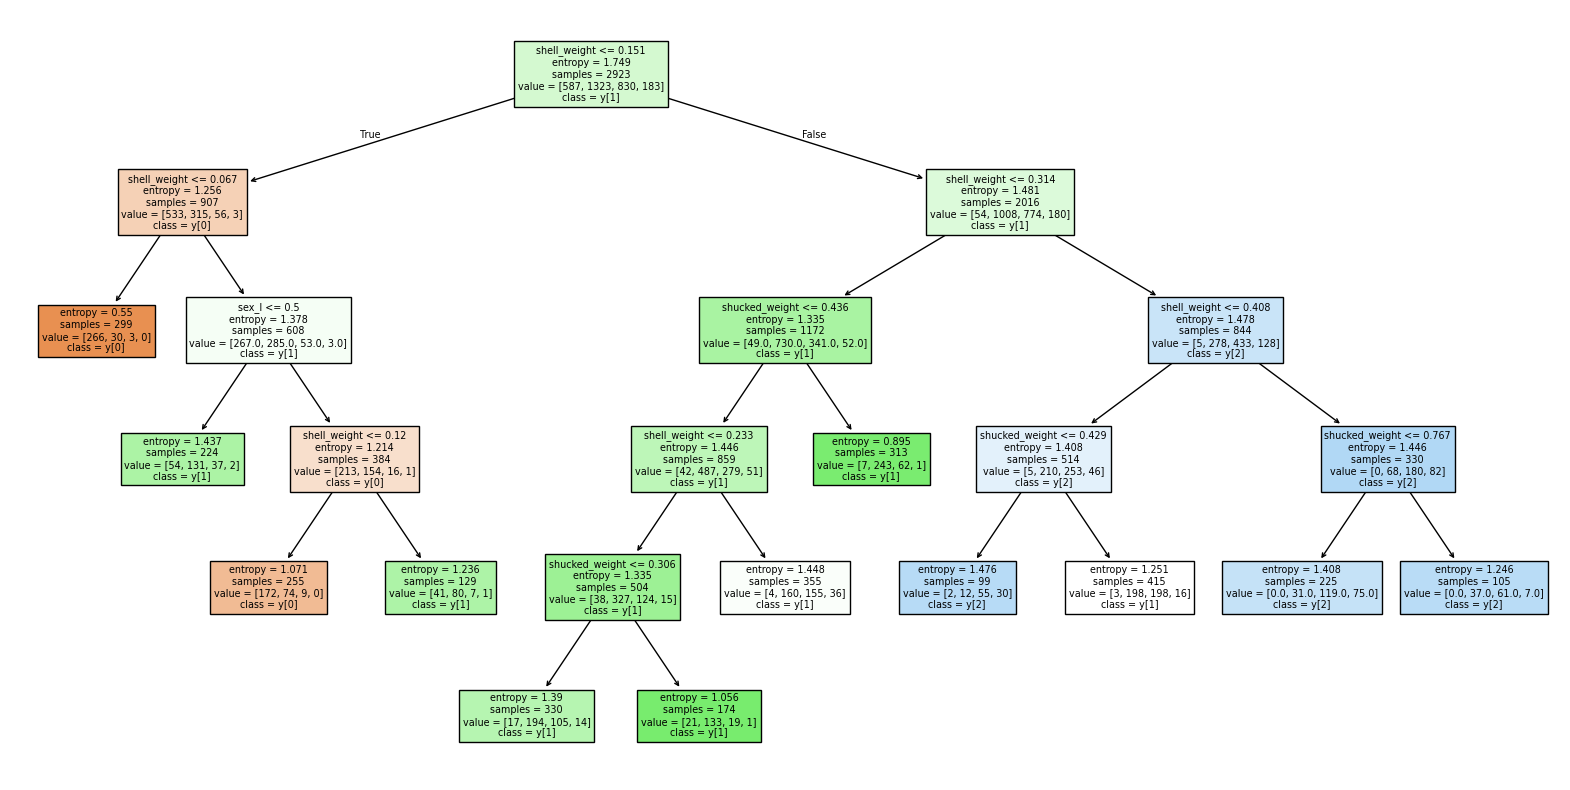

In [19]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(best_clf, filled=True, feature_names=X_train.columns, class_names=True)
plt.show()

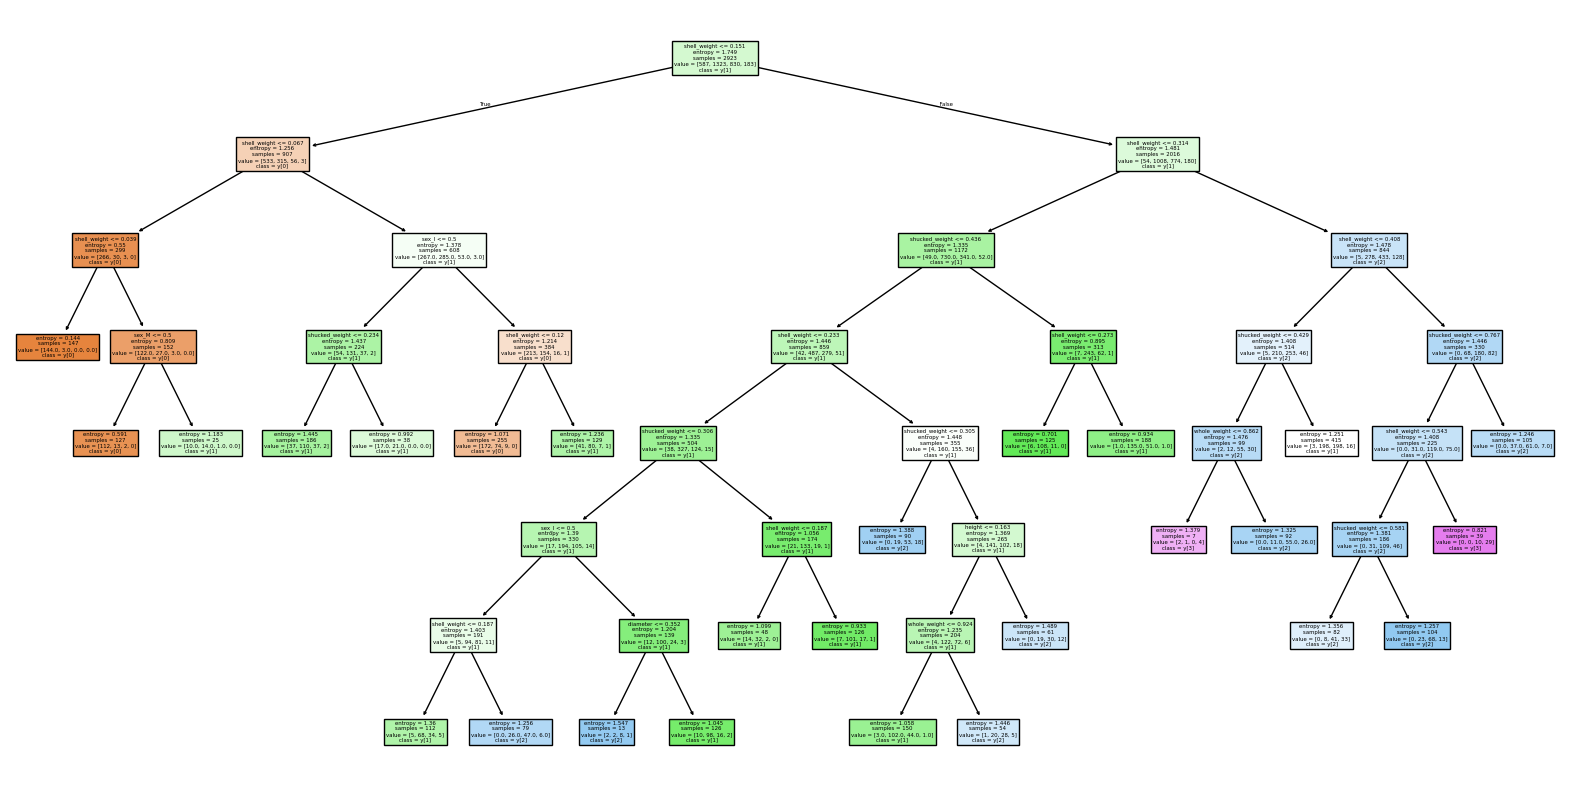

In [22]:
post_prune_params = {
    "criterion": ["gini", "entropy"],
    "ccp_alpha": np.linspace(0.0, 0.1, 50)
}

post_prune_search = RandomizedSearchCV(
    estimator = clf,
    param_distributions=post_prune_params,
    n_iter=50,
    cv=5,
    random_state=42,
    n_jobs=-1
)
post_prune_search.fit(X_train, y_train)
post_prune_best_model = post_prune_search.best_estimator_
plt.figure(figsize=(20, 10))
plot_tree(post_prune_best_model, filled=True, feature_names=X_train.columns, class_names=True)
plt.show()

In [25]:
from sklearn.metrics import roc_auc_score, f1_score

y_test_pred = best_clf.predict(X_test)
y_train_pred = best_clf.predict(X_train)

method = "micro"
underfit_f1 = f1_score(y_train, y_train_pred, average=method)
overfit_f1 = f1_score(y_test, y_test_pred, average=method)
print(underfit_f1, overfit_f1)

0.6199110502907971 0.6148325358851675


In [27]:
y_test_pred = post_prune_best_model.predict(X_test)
y_train_pred = post_prune_best_model.predict(X_train)

method = "micro"
underfit_f1 = f1_score(y_train, y_train_pred, average=method)
overfit_f1 = f1_score(y_test, y_test_pred, average=method)
print(underfit_f1, overfit_f1)

0.6565172767704414 0.6228070175438597


In [5]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2

X = df.drop("age_class", axis=1)
y = df["age_class"]

for i in range(5):
    selector = SelectKBest(score_func=f_classif, k=i+1)
    X_filtered = selector.fit_transform(X, y)
    mask = selector.get_support()
    selected_features = X.columns[mask]
    print(selected_features)

Index(['diameter'], dtype='object')
Index(['length', 'diameter'], dtype='object')
Index(['length', 'diameter', 'shell_weight'], dtype='object')
Index(['length', 'diameter', 'height', 'shell_weight'], dtype='object')
Index(['length', 'diameter', 'height', 'whole_weight', 'shell_weight'], dtype='object')


In [13]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

def feature_selection(X, y, method, k):
        if method == "anova-f":
            selector = SelectKBest(score_func=f_classif, k=k)
        elif method == "mutual_info":
            selector = SelectKBest(score_func=mutual_info_classif, k=k)
        else:
            raise ValueError(f"Unknown selection method, {method}")
        
        selector.fit_transform(X, y)
        mask = selector.get_support()
        return X.columns[mask]

X = df.drop("age_class", axis=1)
y = df["age_class"]
for i in range(1, 10):
    print(f"The top {i} best features using anova-f are", feature_selection(X=X, y=y, method="anova-f", k=i))
    print(f"The top {i} best features using mutual info are", feature_selection(X=X, y=y, method="mutual_info", k=i))

The top 1 best features using anova-f are Index(['diameter'], dtype='object')
The top 1 best features using mutual info are Index(['shell_weight'], dtype='object')
The top 2 best features using anova-f are Index(['length', 'diameter'], dtype='object')
The top 2 best features using mutual info are Index(['height', 'shell_weight'], dtype='object')
The top 3 best features using anova-f are Index(['length', 'diameter', 'shell_weight'], dtype='object')
The top 3 best features using mutual info are Index(['diameter', 'height', 'shell_weight'], dtype='object')
The top 4 best features using anova-f are Index(['length', 'diameter', 'height', 'shell_weight'], dtype='object')
The top 4 best features using mutual info are Index(['diameter', 'height', 'whole_weight', 'shell_weight'], dtype='object')
The top 5 best features using anova-f are Index(['length', 'diameter', 'height', 'whole_weight', 'shell_weight'], dtype='object')
The top 5 best features using mutual info are Index(['length', 'diameter